In [1]:
import datetime
import os
import time
from pathlib import Path
from typing import Dict, List, Optional, Union
import PIL
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import utils as vutils
from dataset import EMnistDataset
import struct

gen_img_root = Path("RGAN/images")
weights_root = Path("RGAN/weights")
gen_img_root.mkdir(parents=True, exist_ok=True)
weights_root.mkdir(parents=True, exist_ok=True)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

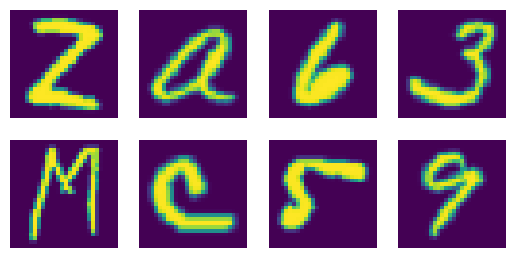

In [2]:
fig, axs = plt.subplots(3, 4)
images = np.load('emnist_img.npy')[:8]
for i, ax in enumerate(axs.flatten()):
    if i < len(images):
        ax.imshow(images[i])
        ax.axis('off')
    else:
        ax.remove()
plt.show()

In [3]:
label = np.load('emnist_label.npy')
print(label.shape, label[0:8])

(697932,) [35 36  6  3 22 38  5  9]


In [4]:
datapath = {'img': 'emnist_img.npy',
            'label':"emnist_label.npy"}

In [5]:
class Parse:
    def __init__(self) -> None:
        self.n_epochs = 100
        self.batch_size = 256
        self.lr = 1e-3
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 100
        self.img_size = 32
        self.channels = 1
        self.sample_interval = 2000
        self.n_critic = 5
        self.rel_avg_gan = True

opt = Parse()

In [6]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 3080


In [7]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
img_shape = (opt.channels, opt.img_size, opt.img_size)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1))

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


In [8]:
from torchvision.transforms import InterpolationMode
# Loss function
adversarial_loss = torch.nn.BCEWithLogitsLoss().to(device)

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
dataloader = DataLoader(
            EMnistDataset(datapath,
                          transform=transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(size=[32,32], interpolation=InterpolationMode.BICUBIC),
                                                transforms.Normalize([0.5], [0.5])]),
                           bonus = False,
            ),
            batch_size = opt.batch_size,
            shuffle=True
        )   

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# record trianing loss
record: Dict[str, List[float]] = {"D_loss": [], "G_loss": []}

In [9]:
def show_images(real_imgs, fake_imgs: None, nrow=6, ncol=6, figsize=(10, 10), save: bool = False, show: bool = True, name=""):
    # compare and show n*m images from generator in one figure and optionally save it
    for imgs, label in zip([imgs for imgs in [real_imgs, fake_imgs] if fake_imgs is not None], ["real", "fake"]):
        imgs = imgs[:nrow * ncol]
        
        imgs = imgs.view(imgs.size(0), opt.channels, opt.img_size, opt.img_size)
        plt.figure(figsize=figsize)
        plt.imshow(np.transpose(vutils.make_grid(imgs, nrow=nrow, padding=2, normalize=True).cpu(), (1, 2, 0)))
        plt.axis('off')
        plt.title(name + label + " images")
        if save:
            plt.savefig(gen_img_root / (name + label + " images.png"))
        if show:
            plt.show()


def to_td(second: Union[int, float]) -> str:
    # convert seconds to time delta
    return str(datetime.timedelta(seconds=int(second)))

 E001B001, [0:00:01/5 days, 15:29:40]  1.79s/epoch D_loss: 0.6932= r0.6932 + f0.6932  G_loss: 0.6969

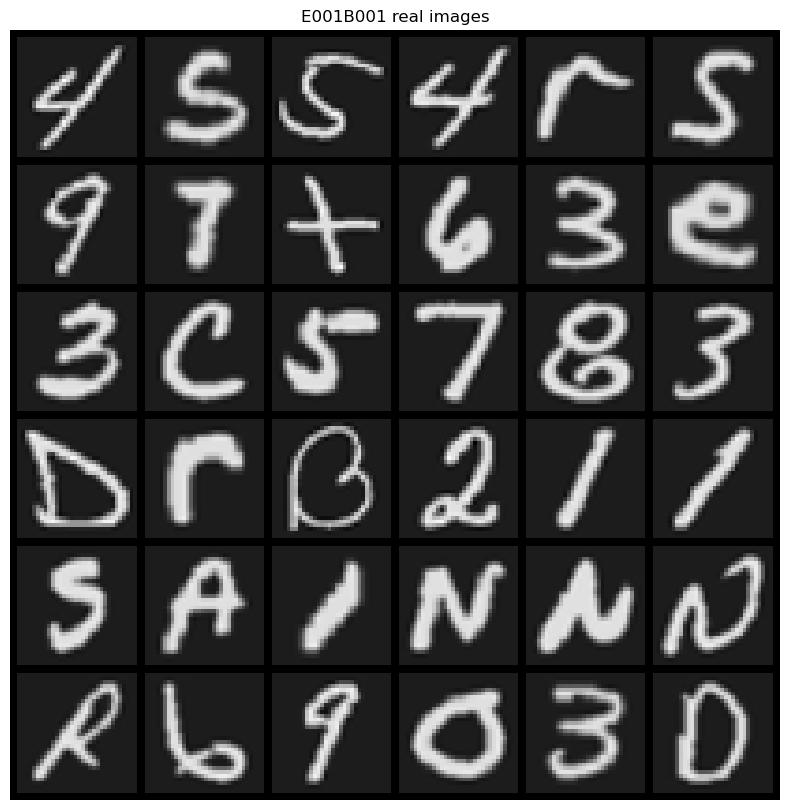

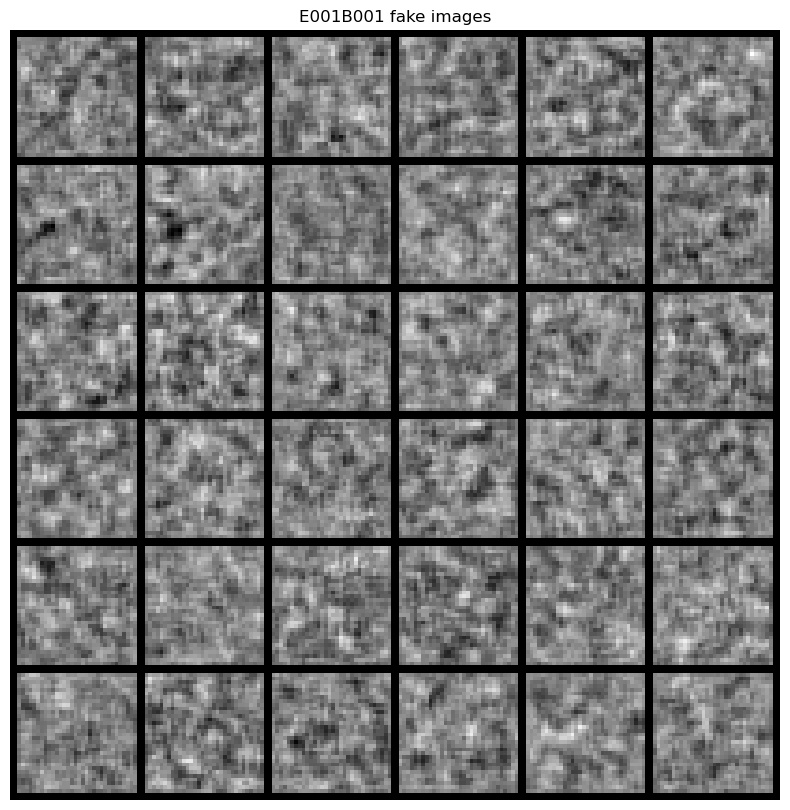

 E001B2710, [0:03:10/5:19:37] 95.61s/epoch D_loss: 0.0008= r0.0009 + f0.0007  G_loss: 0.0044

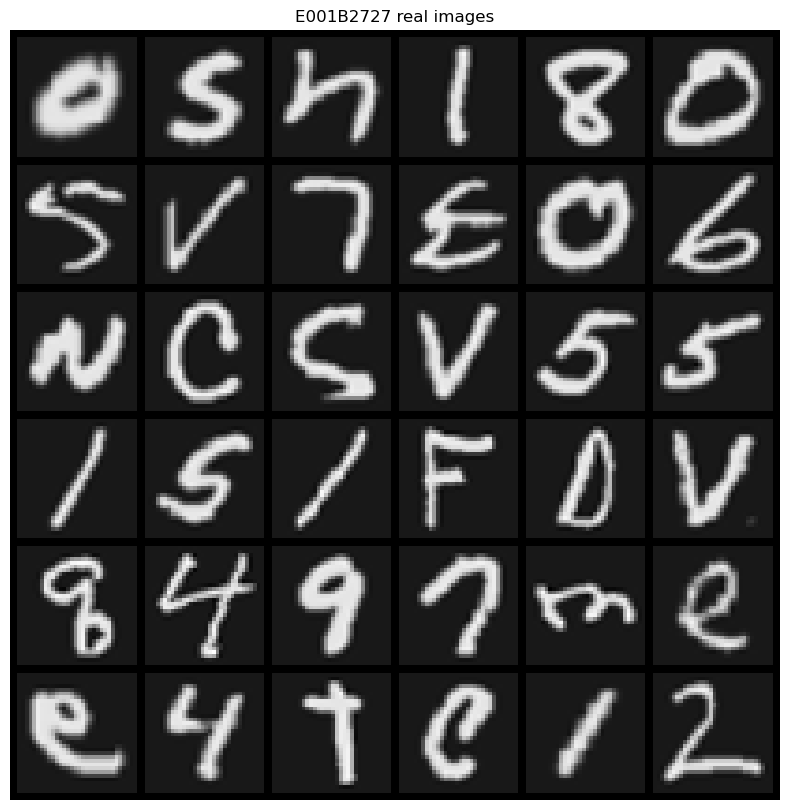

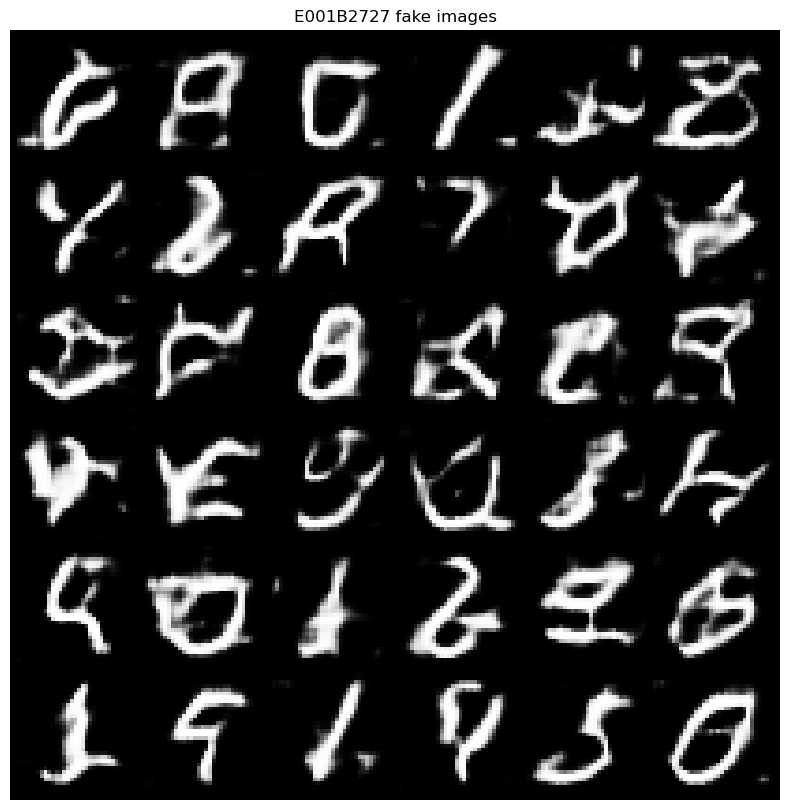

 E010B2716, [0:31:32/5:15:32] 172.12s/epoch D_loss: 0.0000= r0.0000 + f0.0000  G_loss: 51.8189

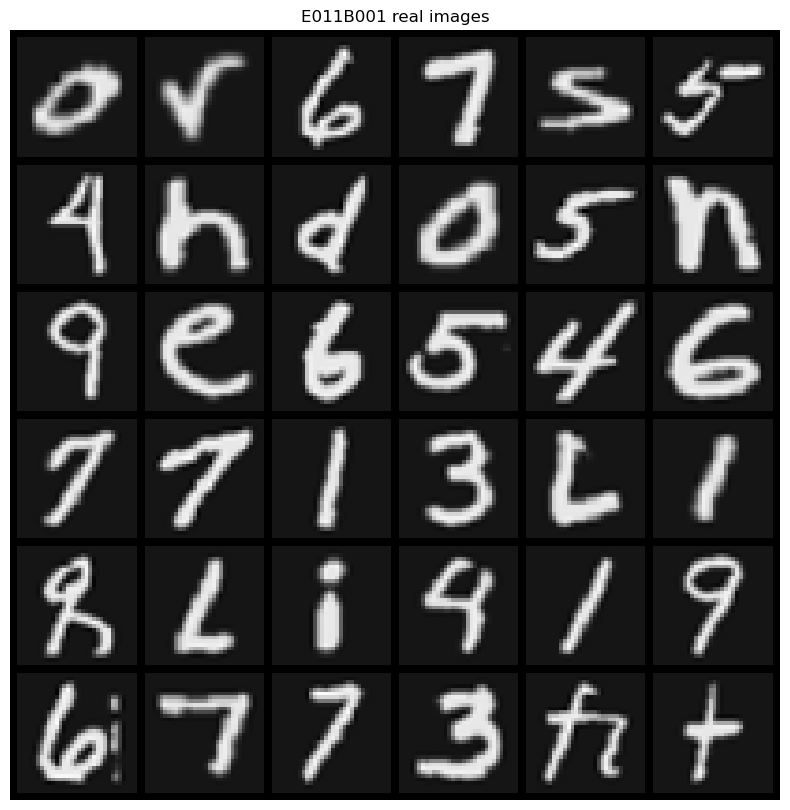

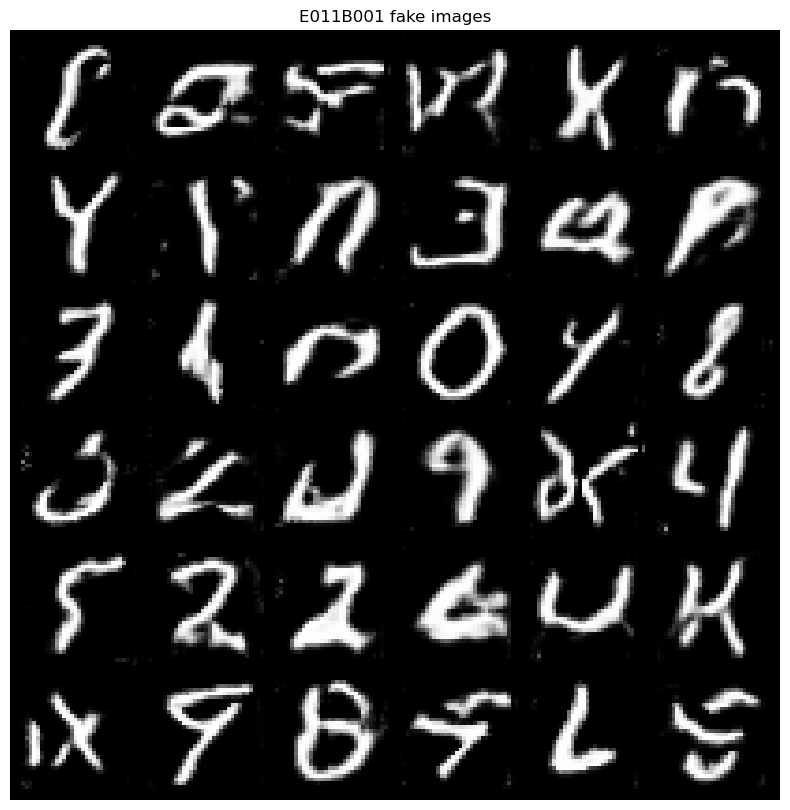

 E011B2719, [0:34:41/5:15:28] 173.51s/epoch D_loss: 0.0014= r0.0027 + f0.0001  G_loss: 29.6220

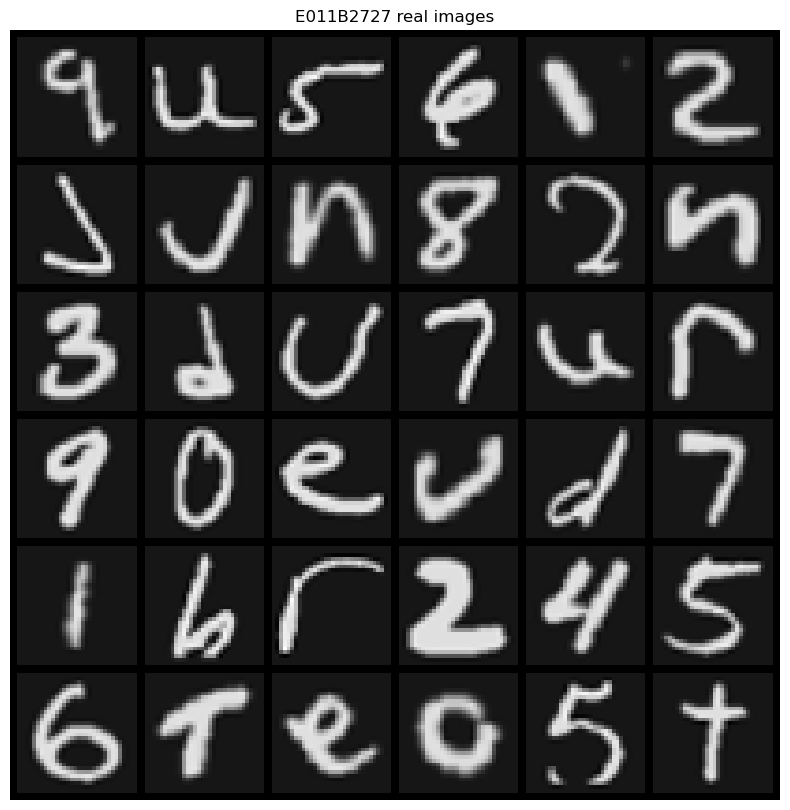

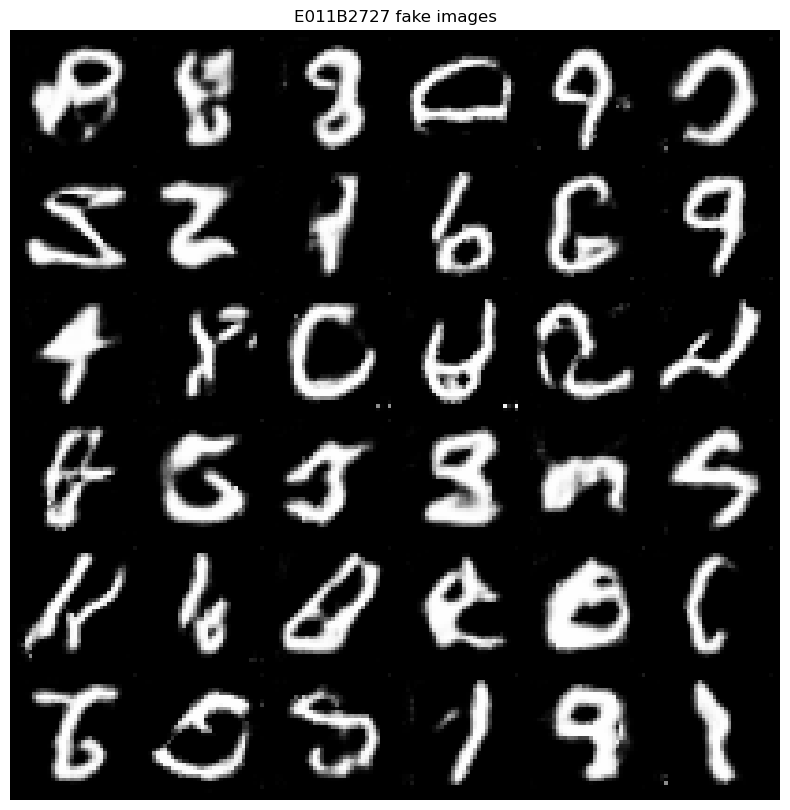

 E020B2725, [1:02:51/5:14:15] 179.58s/epoch D_loss: 0.0008= r0.0010 + f0.0007  G_loss: 74.61198

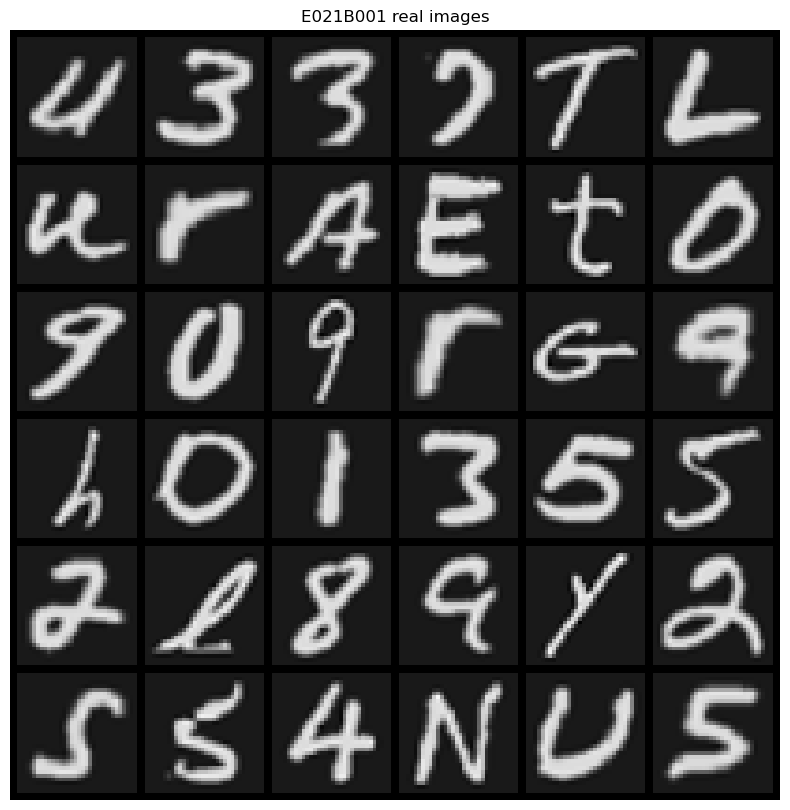

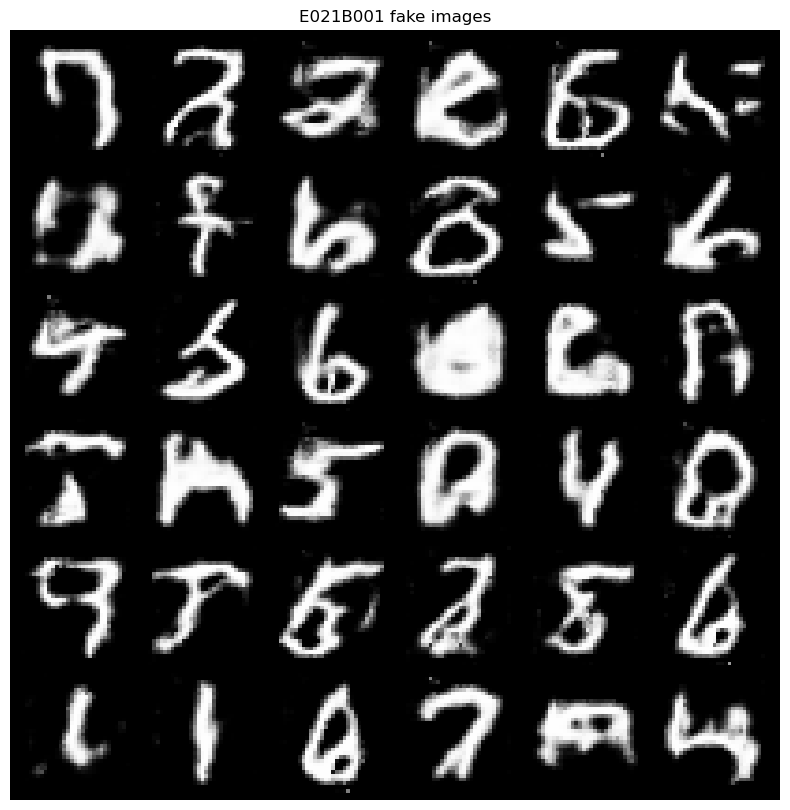

 E021B2707, [1:05:58/5:14:16] 179.99s/epoch D_loss: 0.0000= r0.0000 + f0.0000  G_loss: 63.21301

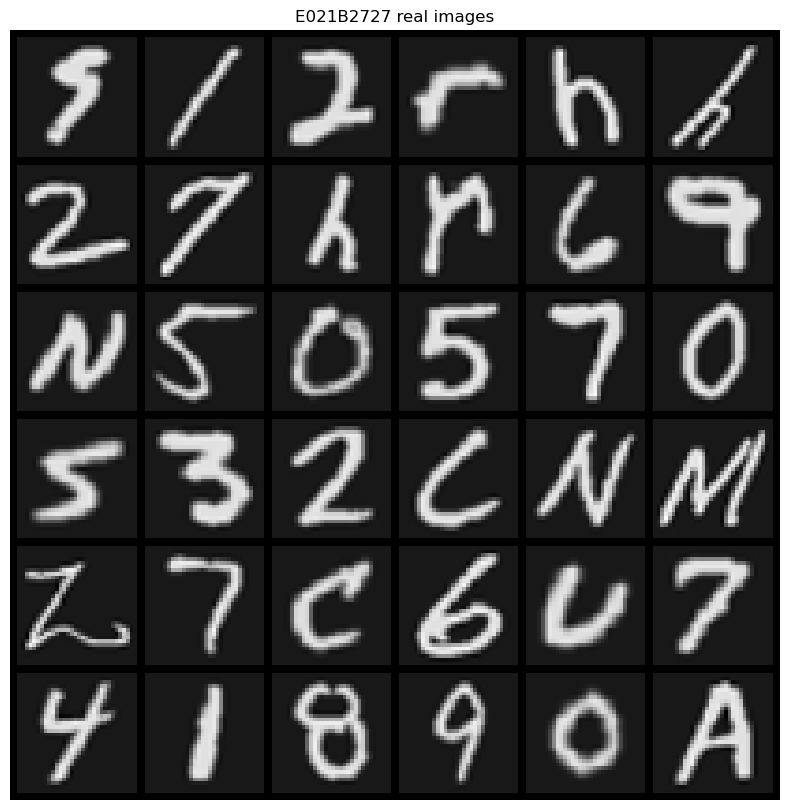

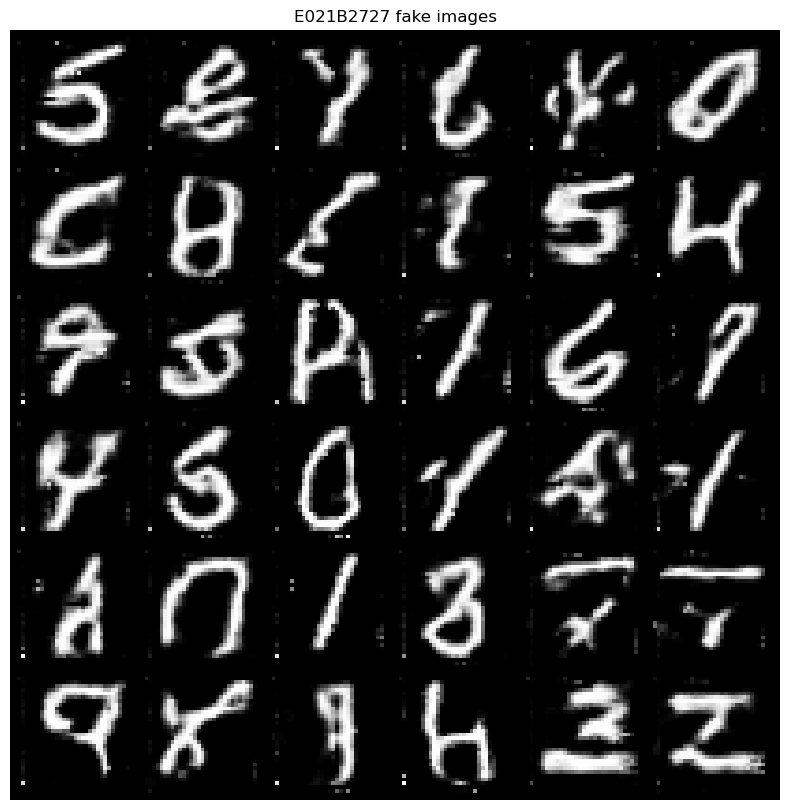

 E030B2713, [1:34:15/5:14:16] 182.48s/epoch D_loss: 0.0000= r0.0000 + f0.0000  G_loss: 128.3625

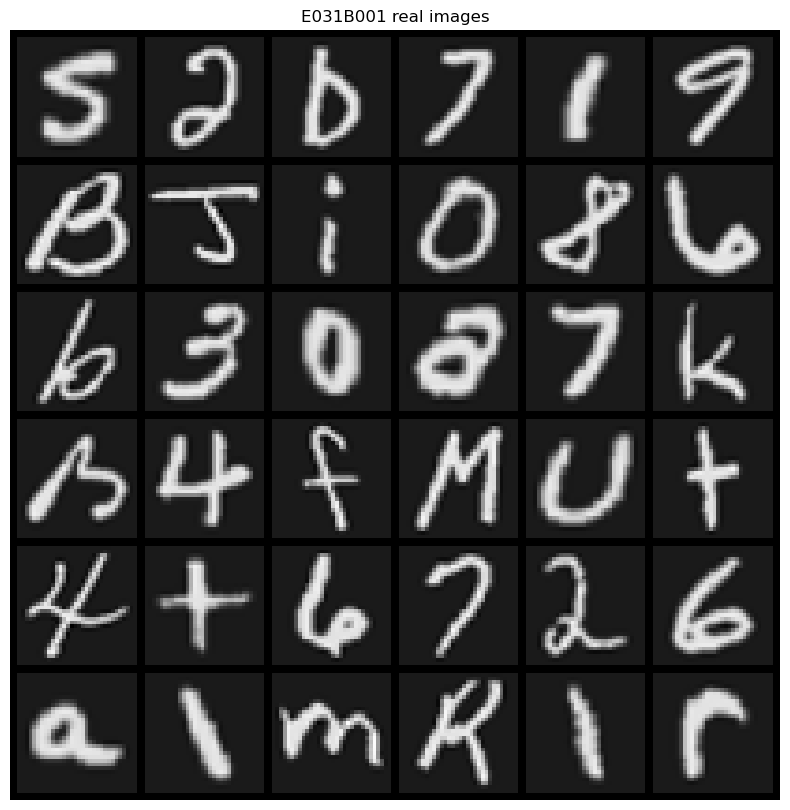

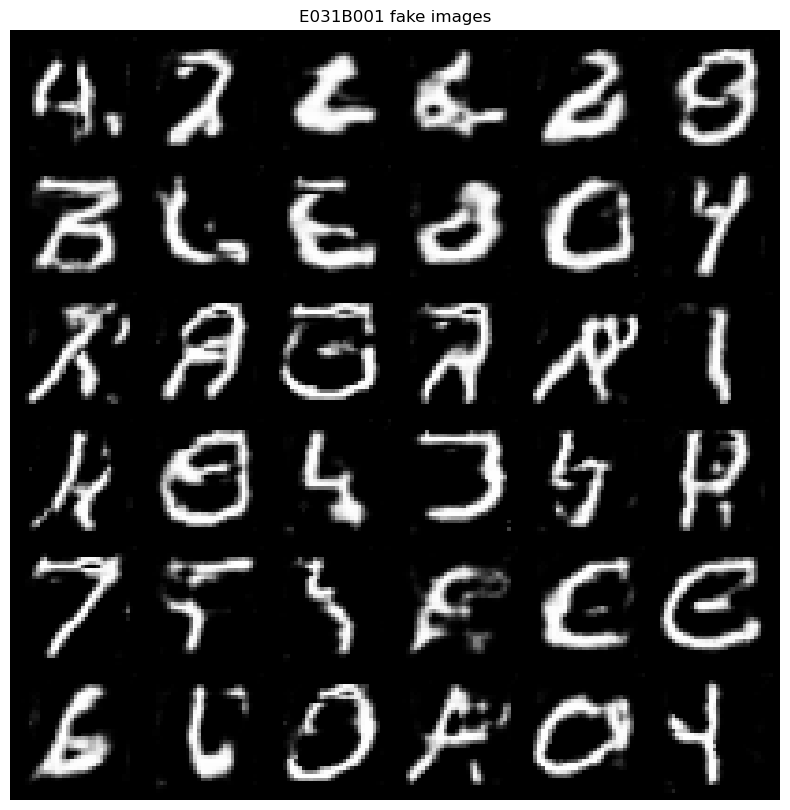

 E031B2716, [1:37:26/5:14:21] 182.72s/epoch D_loss: 0.0000= r0.0000 + f0.0000  G_loss: 96.38796

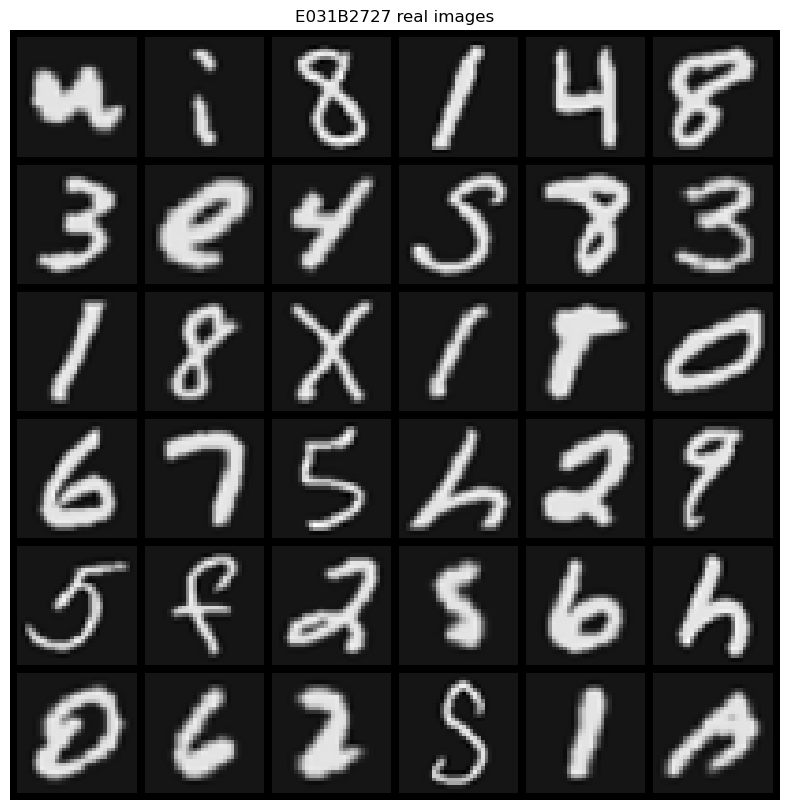

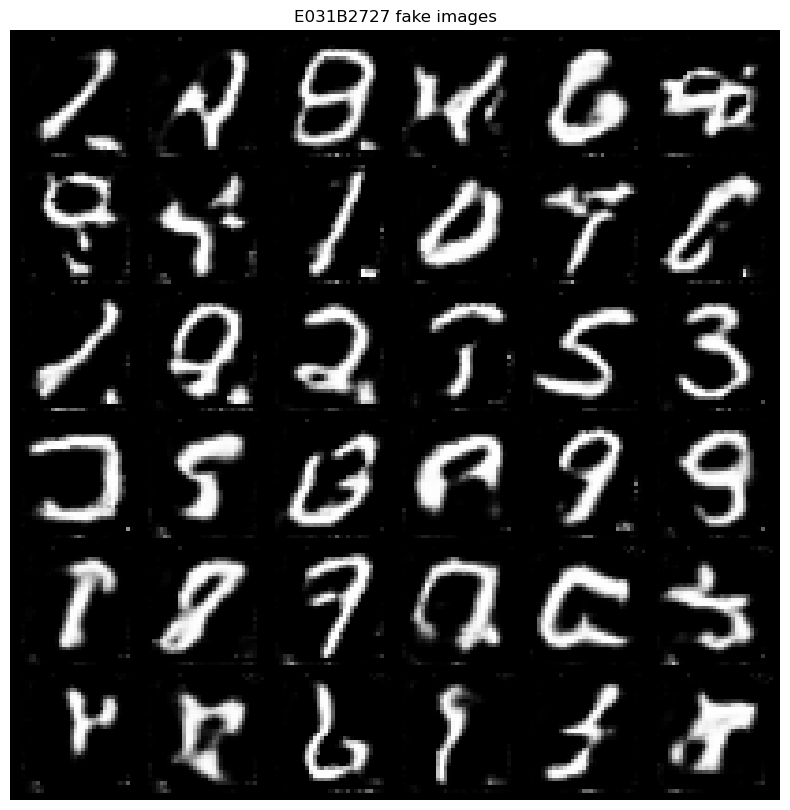

 E040B2722, [2:05:42/5:14:16] 183.97s/epoch D_loss: 0.0000= r0.0000 + f0.0000  G_loss: 119.0794

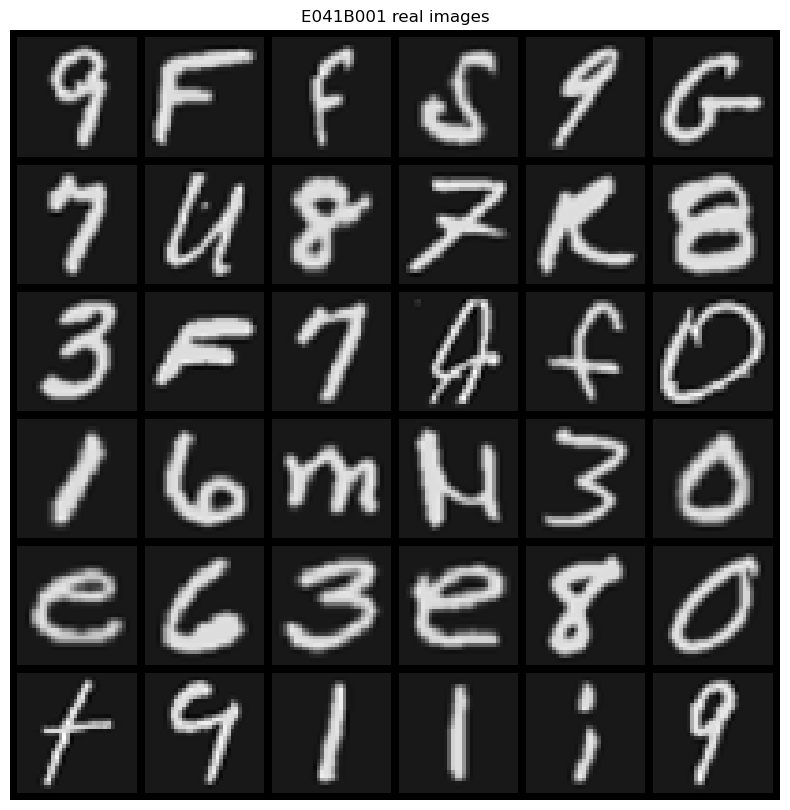

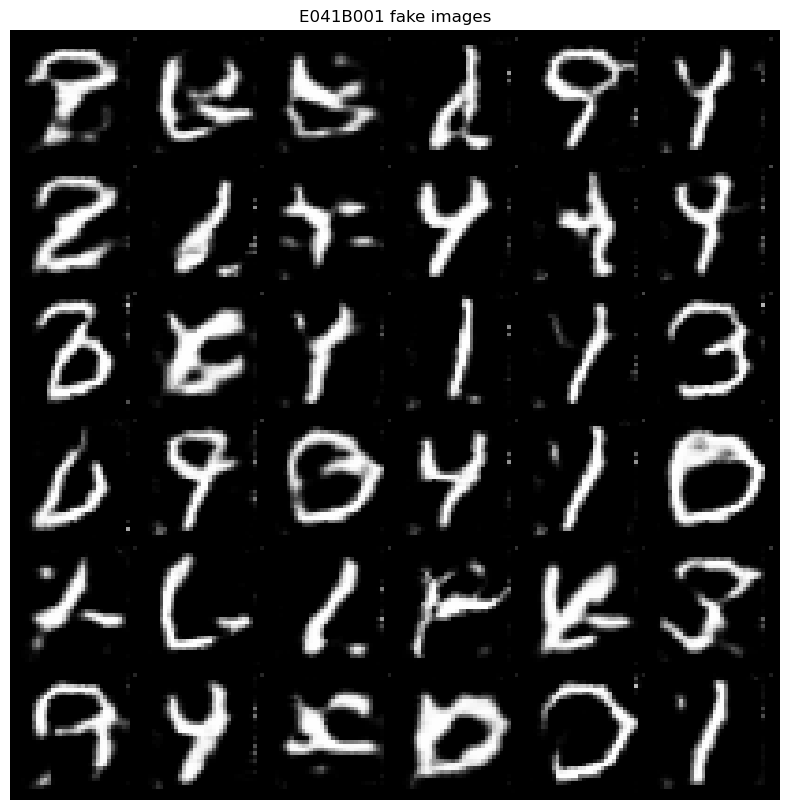

 E041B2725, [2:08:51/5:14:18] 184.09s/epoch D_loss: 0.0000= r0.0000 + f0.0000  G_loss: 100.9075

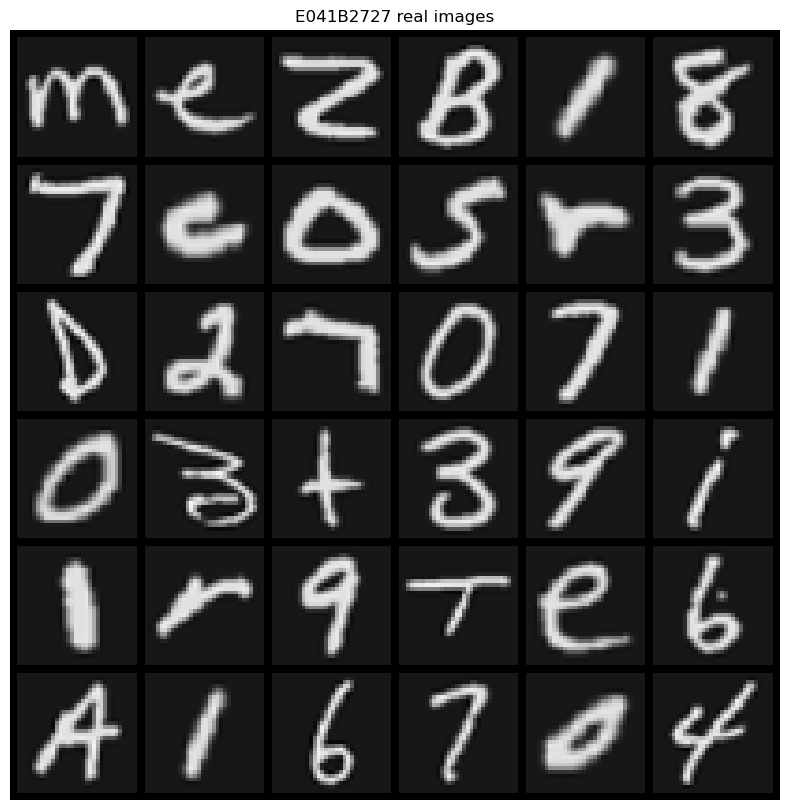

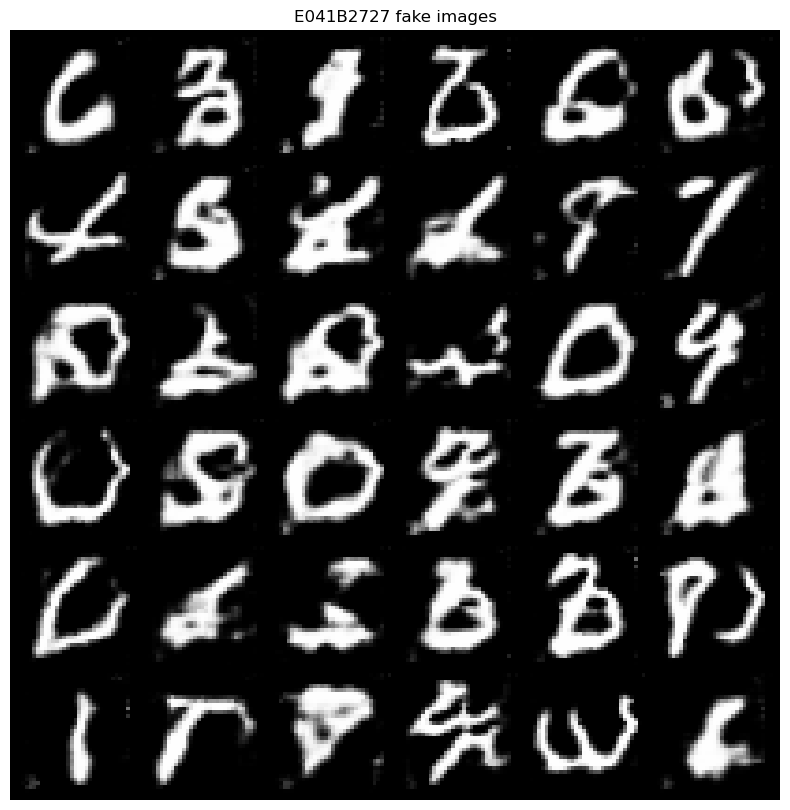

 E043B526, [2:12:36/5:14:18] 184.22s/epoch D_loss: 0.0000= r0.0000 + f0.0000  G_loss: 77.206091

In [ ]:
#  Training
import torch.autograd as autograd
from torch.autograd import Variable
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
result_path = './gan_RGan'
training_start = time.time()

for epoch in range(opt.n_epochs):
    loss_d_e = 0
    loss_g_e = 0
    for i, (imgs,labels) in enumerate(dataloader):
        
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        
        # Configure input
        real_imgs = imgs.to(device)
  
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        # Sample noise as generator input
        z = torch.randn(imgs.size(0), opt.latent_dim).to(device)

        # Generate a batch of images
        fake_imgs = generator(z)
        
            
        real_pred = discriminator(real_imgs).detach()
        fake_pred = discriminator(fake_imgs)

        if opt.rel_avg_gan:
            g_loss = adversarial_loss(fake_pred - real_pred.mean(0, keepdim=True), valid)
        else:
            g_loss = adversarial_loss(fake_pred - real_pred, valid)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(fake_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Predict validity
        real_pred = discriminator(real_imgs)
        fake_pred = discriminator(fake_imgs.detach())

        if opt.rel_avg_gan:
            real_loss = adversarial_loss(real_pred - fake_pred.mean(0, keepdim=True), valid)
            fake_loss = adversarial_loss(fake_pred - real_pred.mean(0, keepdim=True), fake)
        else:
            real_loss = adversarial_loss(real_pred - fake_pred, valid)
            fake_loss = adversarial_loss(fake_pred - real_pred, fake)

        d_loss = (real_loss + fake_loss) / 2



        d_loss.backward()
        optimizer_D.step()

            
        loss_d_e += d_loss.item()
        loss_g_e += g_loss.item()
        batches_done = epoch * len(dataloader) + i

        if batches_done % (opt.sample_interval // 100 + 1) == 0:
            diff = time.time() - training_start
            a_td = to_td(diff)
            al_td = to_td(diff * opt.n_epochs * len(dataloader) / (epoch * len(dataloader) + i + 1))
            per_df = diff / (epoch + 1 + i / len(dataloader))

            print(f"\r E{epoch+1:03}B{i+1:03}, [{a_td}/{al_td}] {per_df:5.2f}s/epoch",
                  f"D_loss: {d_loss.item():6.4f}= r{real_loss.item():6.4f} + f{fake_loss.item():6.4f}",
                  f" G_loss: {g_loss.item():6.4f}",
                  end="")

        if batches_done % opt.sample_interval == 0 and epoch % 5 == 0:
            if batches_done > 10:
                torch.save(generator.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}G.pth")
                torch.save(discriminator.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}D.pth")
        if (epoch % 10 == 0) and (i == 0 or i == len(dataloader) - 1):        
            show_images(real_imgs, fake_imgs, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
        #  final model and result
        if (epoch == opt.n_epochs - 1) and (i == len(dataloader) - 1):
            if not os.path.isdir(result_path):
                os.mkdir(result_path)
            torch.save(generator.state_dict(), result_path + "/Generator weights.pth")
            torch.save(discriminator.state_dict(), result_path + "/Discriminator weights.pth")
            show_images(real_imgs, fake_imgs, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
    record["D_loss"].append(loss_d_e / len(dataloader))
    record["G_loss"].append(loss_g_e / len(dataloader))

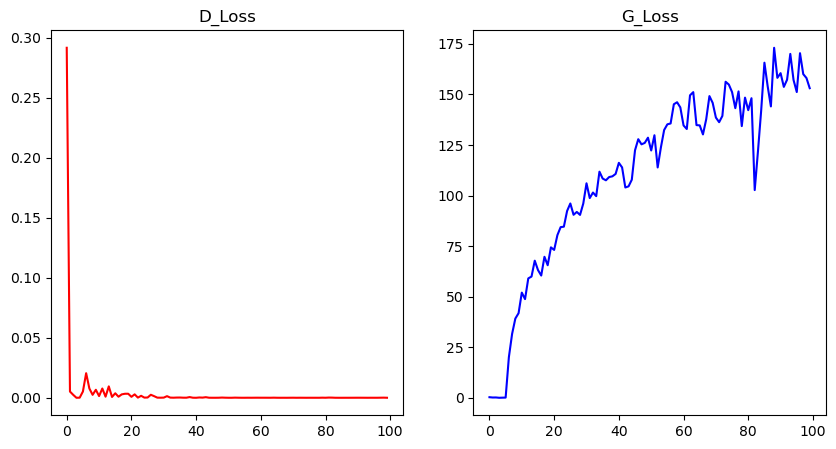

(100,)

In [13]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(record["D_loss"], 'r')   # red line without marker
plt.title('D_Loss')
plt.subplot(122)
plt.plot( record["G_loss"], 'b') # blue solid line with filled circle marker
plt.title('G_Loss')
plt.savefig('RGan_Loss.png')
plt.show()
np.shape(record["G_loss"])

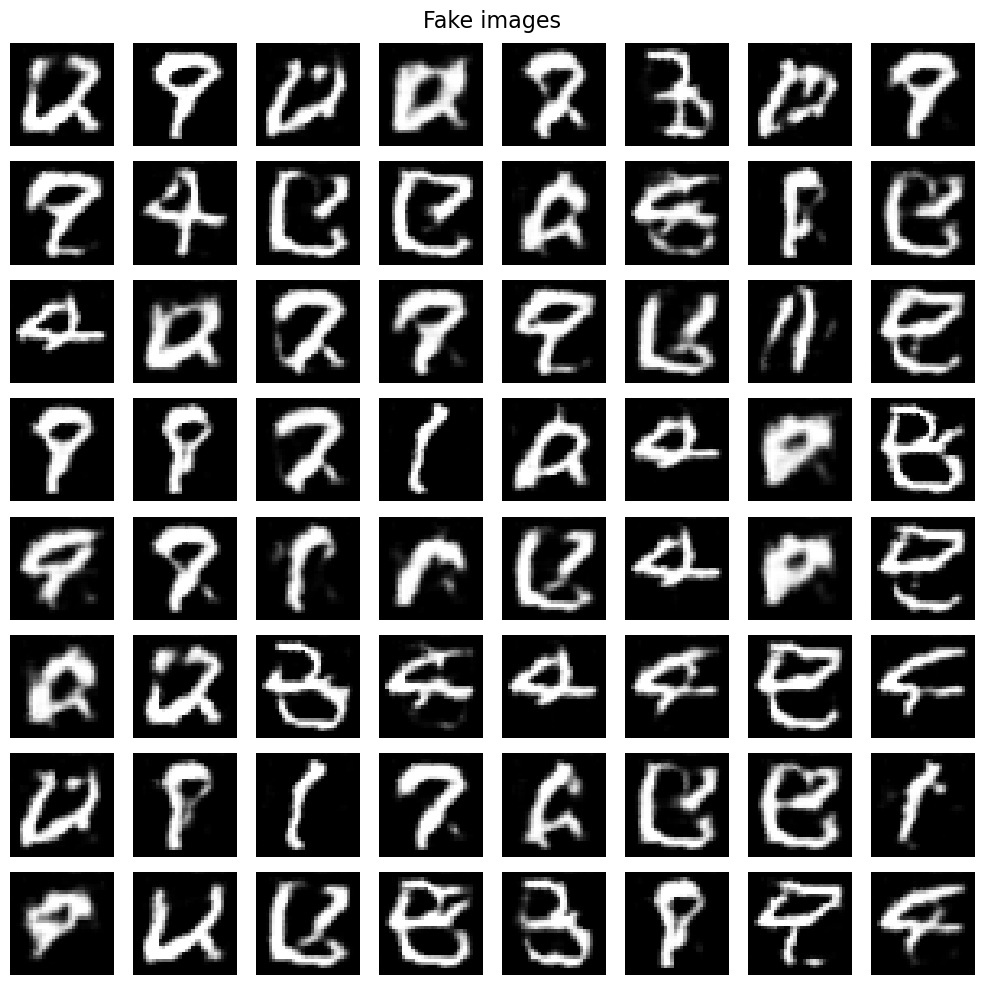

In [14]:
generator = Generator()

generator.load_state_dict(torch.load(result_path + "/Generator weights.pth"))
generator.eval()
z = torch.randn(opt.batch_size, opt.latent_dim)

fake_imgs = generator(z)
fake_imgs.shape

fake_imgs = fake_imgs.view(fake_imgs.size(0), opt.channels, opt.img_size, opt.img_size)

fig, axs = plt.subplots(8, 8, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    if i < len(fake_imgs):
        ax.imshow(fake_imgs[i].detach().numpy().squeeze(), cmap='gray')
        ax.axis('off')
    else:
        ax.remove()
fig.suptitle('Fake images', fontsize=16)
fig.tight_layout()